## Import librairies

In [1]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

load_digits?

In [2]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [3]:
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

<ipython-input-4-5a6f7f88c0c3>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


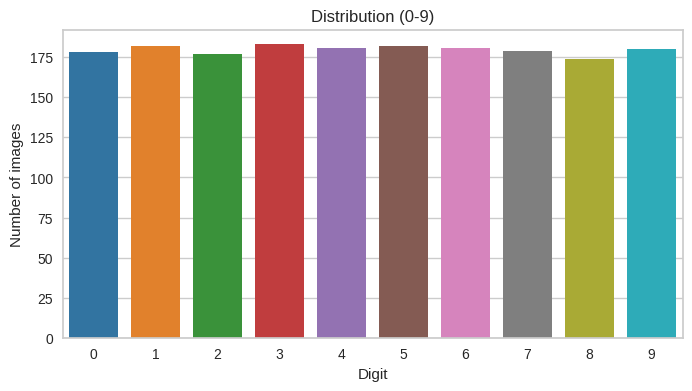

In [4]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

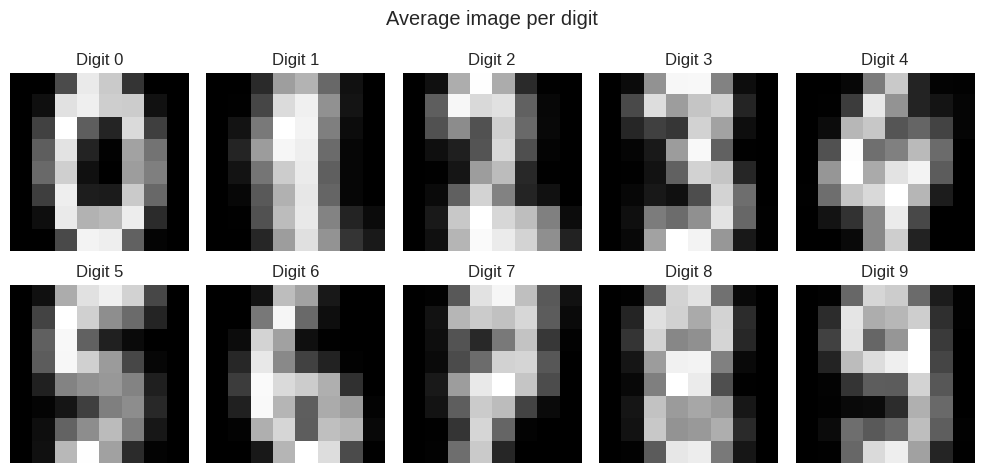

In [5]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)


fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off')
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show()

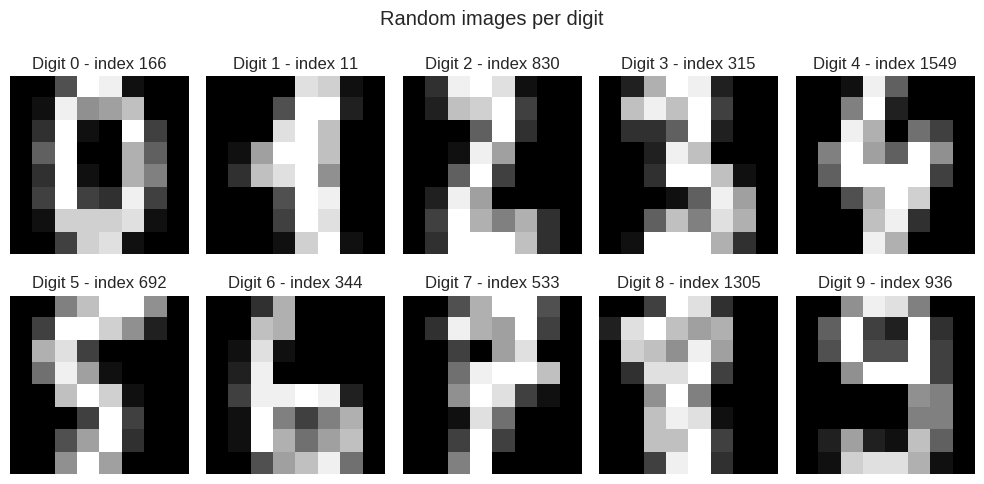

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [8]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]


    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [9]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.189s	4647	0.739	0.747	0.743	0.669	0.180
random   	0.117s	4648	0.735	0.742	0.738	0.667	0.197
PCA-based	0.062s	4647	0.744	0.753	0.749	0.673	0.161
__________________________________________________________________________________


# **1. Optimisation des hyperparamètres du k-means**

In [24]:
import numpy as np
import time
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    adjusted_rand_score,
)

def kmeans_full_report(X, y_true, max_k=10, n_components_pca=0.99, random_state=42):
    scaling_methods = {
        'No scaling': None,
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler(),
        'Normalizer': Normalizer()
    }

    print(110 * "_")
    print("scaler\t\tACP\tk\tinit\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

    best_model_k_sup_9 = {
        'score': -1,
        'details': None,
        'model': None
    }

    for scale_name, scaler in scaling_methods.items():
        if scaler is not None:
            X_scaled = scaler.fit_transform(X)
        else:
            X_scaled = X.copy()

        for mode in ['no_pca', 'with_pca']:
            acp_flag = "Oui" if mode == 'with_pca' else "Non"
            data = X_scaled

            if mode == 'with_pca':
                pca = PCA(n_components=n_components_pca)
                data = pca.fit_transform(X_scaled)
            else:
                pca = None

            best_score = -1
            best_k = 0
            best_info = {}

            for k in range(2, max_k + 1):
                for init_method in ['k-means++', 'random']:
                    start = time.time()
                    kmeans = KMeans(n_clusters=k, random_state=random_state, init=init_method, n_init='auto')
                    labels = kmeans.fit_predict(data)
                    elapsed = time.time() - start
                    silhouette = silhouette_score(data, labels)

                    if silhouette > best_score:
                        best_score = silhouette
                        best_k = k
                        best_info = {
                            'init': init_method,
                            'time': elapsed,
                            'inertia': kmeans.inertia_,
                            'homo': homogeneity_score(y_true, labels),
                            'compl': completeness_score(y_true, labels),
                            'v-meas': v_measure_score(y_true, labels),
                            'ARI': adjusted_rand_score(y_true, labels),
                            'silhouette': silhouette
                        }

                    if k > 9 and silhouette > best_model_k_sup_9['score']:
                        best_model_k_sup_9['score'] = silhouette
                        best_model_k_sup_9['details'] = {
                            'scaler': scale_name,
                            'pca': acp_flag,
                            'k': k,
                            'init': init_method,
                            'time': elapsed,
                            'inertia': kmeans.inertia_,
                            'homo': homogeneity_score(y_true, labels),
                            'compl': completeness_score(y_true, labels),
                            'v-meas': v_measure_score(y_true, labels),
                            'ARI': adjusted_rand_score(y_true, labels),
                            'silhouette': silhouette
                        }
                        best_model_k_sup_9['model'] = kmeans
                        best_model_k_sup_9['scaler'] = scaler
                        best_model_k_sup_9['pca'] = pca

            print(f"{scale_name:<15}{acp_flag:<6}\t{best_k:<2}\t{best_info['init']}\t"
                  f"{best_info['time']:.4f}\t{best_info['inertia']:.0f}\t"
                  f"{best_info['homo']:.4f}\t{best_info['compl']:.4f}\t"
                  f"{best_info['v-meas']:.4f}\t{best_info['ARI']:.4f}\t{best_info['silhouette']:.4f}")

    if best_model_k_sup_9['details']:
        print("\n" + 110 * "_")
        print("Meilleur modèle avec k > 9 basé sur le score de silhouette :")
        for k, v in best_model_k_sup_9['details'].items():
            print(f"{k}: {v}")
    else:
        print("\nAucun modèle avec k > 9 n’a été trouvé ou aucun n’a dépassé le score seuil.")

    return best_model_k_sup_9


result = kmeans_full_report(X, labels)


______________________________________________________________________________________________________________
scaler		ACP	k	init	time	inertia	homo	compl	v-meas	ARI	silhouette
No scaling     Non   	9 	random	0.1262	1202400	0.6893	0.7473	0.7171	0.5939	0.1891
No scaling     Oui   	9 	random	0.0968	1181021	0.6949	0.7548	0.7236	0.5989	0.1921
StandardScaler Non   	2 	k-means++	0.0083	104910	0.0126	0.2778	0.0241	0.0006	0.3865
StandardScaler Oui   	2 	k-means++	0.0084	103897	0.0126	0.2778	0.0241	0.0006	0.3877
MinMaxScaler   Non   	9 	random	0.1140	4794	0.6933	0.7522	0.7215	0.5986	0.1882
MinMaxScaler   Oui   	9 	random	0.0927	4716	0.6933	0.7522	0.7215	0.5986	0.1904
RobustScaler   Non   	2 	k-means++	0.0080	68374	0.0422	0.2878	0.0736	0.0104	0.4087
RobustScaler   Oui   	2 	k-means++	0.0068	67495	0.0422	0.2878	0.0736	0.0104	0.4117
Normalizer     Non   	9 	k-means++	0.0187	308	0.6908	0.7478	0.7182	0.5946	0.1923
Normalizer     Oui   	9 	k-means++	0.0139	302	0.6838	0.7411	0.7113	0.5875	0.1951

_____

Pour juger de la qualité du modèle, nous nous refererons au score de silhouette.
Ainsi, le meilleur modèle propose un total de **10 clusters** avec la méthode de standardisation **normalizer**, comme init **k-means++**, une réduction de dimension permettant de conserver **99%** de l'information totale et un score de silhouette de **19,18%**.

# **2. Profiling analysis : cluster persona**

In [27]:
reduced_data = PCA(n_components=0.99).fit_transform(X)
kmeans = KMeans(init="k-means++", n_clusters=10, n_init='auto')
kmeans.fit(reduced_data)

kmean_labels = kmeans.labels_

In [28]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,6
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,7
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,7
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,8
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,4


In [30]:
# Mapping cluster => label
data = pd.DataFrame(reduced_data)
data["cluster"] = kmean_labels
data["label"] = labels

contingency_table = pd.crosstab(data["cluster"], data["label"])
print(contingency_table)

label      0    1    2    3    4    5    6    7    8    9
cluster                                                  
0          0    0    2    7    7    0    0  176    3    7
1          0    3    9    7    3    0    1    3  135    4
2          0    2    0    0    0    2  176    0    1    0
3          0   22    4   10    0   41    0    0   16  159
4          2    0    0    0  164    2    0    0    0    3
5          0    1    0    2    0  137    0    0    2    4
6        176    0    1    0    0    0    1    0    0    0
7          0  130    6    0    7    0    3    0   14    1
8          0    1    6  156    0    0    0    0    0    2
9          0   23  149    1    0    0    0    0    3    0


In [31]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    7
1    8
2    6
3    9
4    4
5    5
6    0
7    1
8    3
9    2
dtype: int64


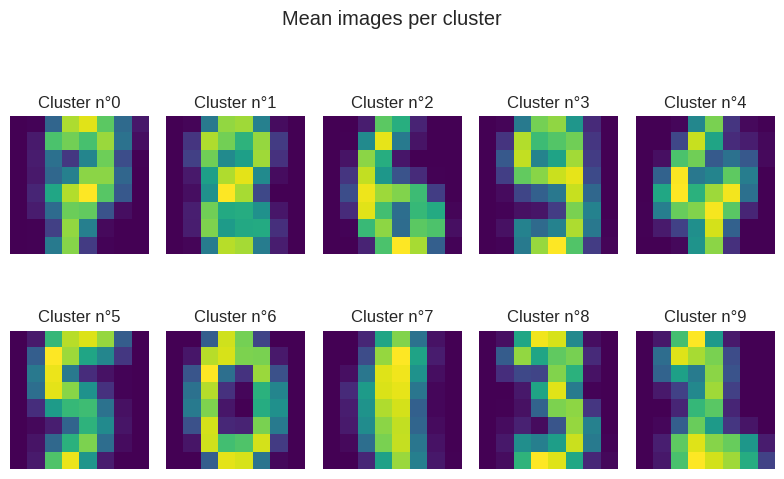

In [40]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)

    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='viridis')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')

plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

Les différentes représentations nous donnent le chiffre moyen dans chaque cluster. Le modèle parvient à assez bien classer les chiffres car nous n'avons pas de répétition (chaque chiffre se trouve dans un cluster bien déterminé).

# **3. Visualisation avec le t-sne**

In [36]:
from sklearn.manifold import TSNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


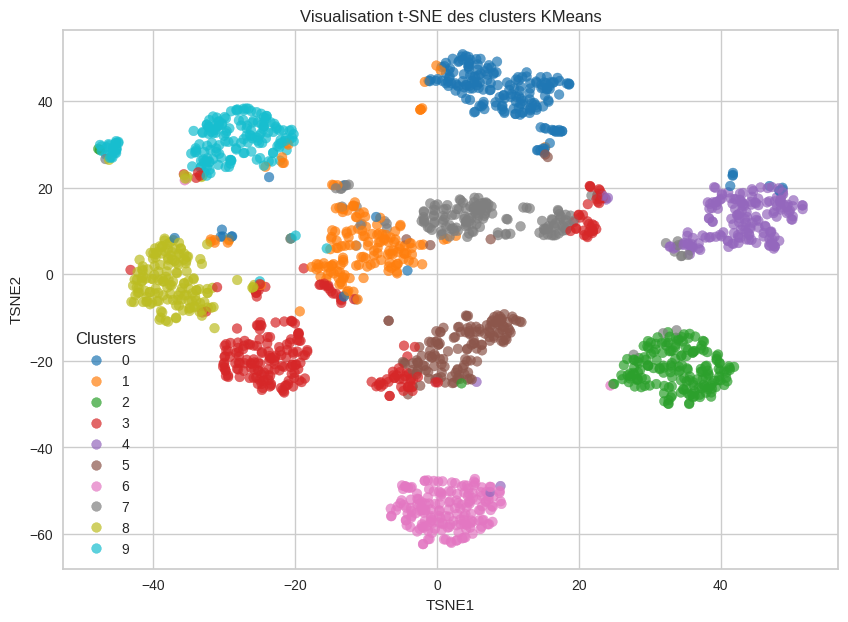

In [39]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(reduced_data)

df_visu = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
df_visu["cluster"] = kmean_labels
df_visu["label"] = labels


plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_visu["TSNE1"], df_visu["TSNE2"], c=df_visu["cluster"], cmap="tab10", alpha=0.7)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title("Visualisation t-SNE des clusters KMeans")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()


On observe une certaine homogénéité des clusters avec peu de confusion.